In [100]:
# 1.1 Import tensorflow and other libraries.
import tensorflow as tf
from tensorflow.python.client import timeline

import numpy as np

%matplotlib inline
import pylab

In [101]:
tf.reset_default_graph()

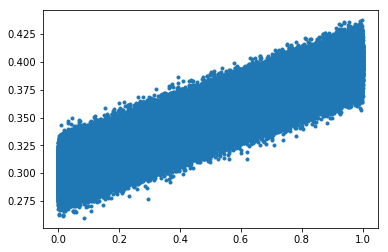

In [102]:
# 1.2 Create input data using NumPy. y = x * 0.1 + 0.3 + noise
x_train = np.random.rand(1000000).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_train))
y_train = x_train * 0.1 + 0.3 + noise

# Pplot our input data.
pylab.plot(x_train, y_train, '.')

In [103]:
# Create some fake test/validation data
x_test = np.random.rand(len(x_train)).astype(np.float32)
noise = np.random.normal(scale=0.01, size=len(x_train))
y_test = x_test * 0.1 + 0.3 + noise

In [104]:
# 1.3 Build inference graph.
# Create Variables W and b that compute y_data = W * x_data + b
with tf.device("/cpu:0"):
  W = tf.get_variable(shape=[], name='weights')
  print(W)

  b = tf.get_variable(shape=[], name='bias')
  print(b)

# Create a placeholder we'll use later to feed x's into the graph for training and test.
# shape=[None] means we can put in any number of examples. 
# This is used for minibatch training, and to evaluate a lot of examples at once.
x = tf.placeholder(shape=[None], dtype=tf.float32, name='x')

print(x)

# This is the same as tf.add(tf.mul(W, x), b), but looks nicer
y = W * x + b
    
#  print(tf.device.name)

Tensor("weights/read:0", shape=(), dtype=float32, device=/device:CPU:0)
Tensor("bias/read:0", shape=(), dtype=float32, device=/device:CPU:0)
Tensor("x:0", shape=(?,), dtype=float32)


In [105]:
# Write the graph so we can look at it in TensorBoard
# Now is a good time to try that
from datetime import datetime 

time = datetime.now().time()

sw = tf.summary.FileWriter('/root/tensorboard/linear/%s' % time, graph=tf.get_default_graph())

In [106]:
# Create a placeholder we'll use later to feed the correct y value into the graph
y_ = tf.placeholder(shape=[None], dtype=tf.float32, name='y_')
print(y_)

Tensor("y_:0", shape=(?,), dtype=float32)


In [107]:
# 1.4 Build training graph.
# Create an operation that calculates loss.

with tf.device('/cpu:0'):
  loss = tf.reduce_mean(tf.square(y - y_))  

  # Create an optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5)  

  # Create an operation that minimizes loss.
  train = optimizer.minimize(loss)  

  # 'loss', 'optimizer' and 'train' are.
  print("loss:", loss)
  print("optimizer:", optimizer)
  print("train:", train)

loss: Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
optimizer: <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7f61400fcef0>
train: name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



In [108]:
# Create an operation to initialize all the variables.
init_op = tf.global_variables_initializer()
print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [109]:
config = tf.ConfigProto(
    #device_count={'CPU':1, 'GPU': 1},
                        log_device_placement=True)
#config.gpu_options.allow_growth=True
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1


In [110]:
sess = tf.Session(config=config)
sess.run(init_op)

## Accuracy of Random Weights

In [111]:
# Calculate accuracy on the evaluation data before training
def test():
  return sess.run(loss, feed_dict={x: x_test, y_: y_test})

test()

1.9594994

In [112]:
# Add a Summary Operation so we can visualize the loss in TensorBoard
scalar_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([scalar_summary])

In [113]:
# Write the graph so we can look at it in TensorBoard
# Now is a good time to try that
sw = tf.summary.FileWriter('/root/tensorboard/linear/%s' % time, graph=sess.graph)

# Train Model

In [114]:
%%time

max_steps = 1001

run_metadata = tf.RunMetadata()

for step in range(max_steps):
  # Run the training op; feed the training data into the graph
  if (step == (max_steps - 1)):
    summary_str, _ = sess.run([summary_op, train], feed_dict={x: x_train, y_: y_train}, options=tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE), run_metadata=run_metadata)
    trace = timeline.Timeline(step_stats=run_metadata.step_stats)
    with open('timeline.ctf.json', 'w') as trace_file:
      trace_file.write(trace.generate_chrome_trace_format(show_memory=True))
  else:  
    summary_str, _ = sess.run([summary_op, train], feed_dict={x: x_train, y_: y_train})

  sw.add_summary(summary_str, step)
  # Watch training happen real time.
#  if step % 20 == 0:
#    print(step, sess.run([W, b]))

CPU times: user 30.8 s, sys: 30.5 s, total: 1min 1s
Wall time: 18.3 s


In [115]:
# Write the graph so we can look at it in TensorBoard
# Now is a good time to try that
sw = tf.summary.FileWriter('/root/tensorboard/linear/%s' % time, graph=sess.graph)

(0, 1.0)

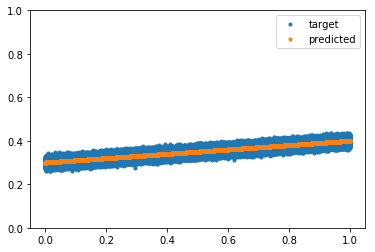

In [116]:
# 1.8 Plot the predicted values
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y, feed_dict={x: x_train, y_: y_train}), ".", label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

In [117]:
# Check accuracy on eval data after training
test()

9.9948047e-05

Demonstrate saving and restoring a model

In [89]:
#def predict(x_in): return sess.run(y, feed_dict={x: [x_in]})

In [90]:
# Save the model
#saver = tf.train.Saver()
#saver.save(sess, './my_checkpoint.ckpt')

In [91]:
# Current prediction
#predict(3)

In [92]:
# Reset the model by running the init op again
#sess.run(init_op) 

In [93]:
# Prediction after variables reinitialized
#predict(3)

In [94]:
#saver.restore(sess, './my_checkpoint.ckpt')

In [95]:
# Predictions after variables restored
#predict(3)

In [119]:
#https://github.com/tensorflow/serving/blob/master/tensorflow_serving/example/mnist_saved_model.py

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat

time = datetime.now().time()

# Save the model
export_path = "./export/%s" % time

builder = saved_model_builder.SavedModelBuilder(export_path)

tensor_info_x = utils.build_tensor_info(x)
print(tensor_info_x)

tensor_info_y_ = utils.build_tensor_info(y_)
print(tensor_info_y_)

prediction_signature = \
  signature_def_utils.build_signature_def( \
    inputs = {'images': tensor_info_x}, \
    outputs = {'scores': tensor_info_y_} \
  )                                                               
with tf.Session(graph=tf.Graph()) as sess:
  builder.add_meta_graph_and_variables(sess,[tag_constants.SERVING], signature_def_map={'predict_images':prediction_signature, signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature})


name: "x:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

name: "y_:0"
dtype: DT_FLOAT
tensor_shape {
  dim {
    size: -1
  }
}

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
